# Comparación de Escenarios SSP para Producción H2V

## 🎯 Objetivo
Comparar los resultados de producción de H2V bajo diferentes escenarios climáticos:
- **SSP245**: Escenario intermedio (forzamiento radiativo 4.5 W/m²)
- **SSP370**: Escenario medio-alto (7.0 W/m²)
- **SSP585**: Escenario alto (8.5 W/m²)

## 📊 Análisis Incluidos
1. Comparación de producción total H2 por escenario
2. Distribuciones espaciales de LCOH y capacidades
3. Evolución temporal de Capacity Factor (CF)
4. Mapas comparativos de potencial H2 por ubicación
5. Análisis estadístico y sensibilidad climática

---

## 1️⃣ Imports y Configuración

In [1]:
# Imports
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 11
%matplotlib inline

print("✓ Imports completados")

✓ Imports completados


## 2️⃣ Configuración de Rutas

In [2]:
# Rutas del proyecto
BASE_DIR = Path('/home/aninotna/magister/tesis/justh2_pipeline')
DATA_DIR = BASE_DIR / 'data'
RESULTS_DIR = DATA_DIR / 'h2v_production_spatial' / 'distributed_point_by_point'
PV_CF_DIR = DATA_DIR / 'pv_cf' / 'netcdf'
PLOTS_DIR = BASE_DIR / 'plots' / 'ssp_comparison'
PLOTS_DIR.mkdir(exist_ok=True, parents=True)

# Modo de ejecución
MODE = 'test'  # 'test' o 'full'

# Escenarios a comparar
SCENARIOS = ['ssp245', 'ssp370', 'ssp585']

print("=" * 80)
print("⚙️ CONFIGURACIÓN")
print("=" * 80)
print(f"\n📁 Rutas:")
print(f"   Resultados: {RESULTS_DIR}")
print(f"   CF Data: {PV_CF_DIR}")
print(f"   Plots: {PLOTS_DIR}")
print(f"\n🎯 Parámetros:")
print(f"   Modo: {MODE.upper()}")
print(f"   Escenarios: {', '.join([s.upper() for s in SCENARIOS])}")
print("=" * 80)

⚙️ CONFIGURACIÓN

📁 Rutas:
   Resultados: /home/aninotna/magister/tesis/justh2_pipeline/data/h2v_production_spatial/distributed_point_by_point
   CF Data: /home/aninotna/magister/tesis/justh2_pipeline/data/pv_cf/netcdf
   Plots: /home/aninotna/magister/tesis/justh2_pipeline/plots/ssp_comparison

🎯 Parámetros:
   Modo: TEST
   Escenarios: SSP245, SSP370, SSP585


## 3️⃣ Cargar Resultados de los 3 Escenarios

In [3]:
# Cargar resultados CSV
print("Cargando resultados de escenarios...\n")

results = {}

for scenario in SCENARIOS:
    csv_file = RESULTS_DIR / f'h2_distributed_{scenario}_{MODE}.csv'
    
    if csv_file.exists():
        df = pd.read_csv(csv_file)
        df_success = df[df['status'] == 'success'].copy()
        
        results[scenario] = {
            'df_all': df,
            'df': df_success,
            'n_total': len(df),
            'n_success': len(df_success),
            'success_rate': len(df_success) / len(df) * 100
        }
        
        print(f"✓ {scenario.upper()}: {len(df_success)}/{len(df)} puntos exitosos ({len(df_success)/len(df)*100:.1f}%)")
    else:
        print(f"⚠️ {scenario.upper()}: Archivo no encontrado - {csv_file.name}")

print(f"\n✓ {len(results)} escenarios cargados")

# Verificar que todos los escenarios estén disponibles
if len(results) < 3:
    print("\n⚠️ ADVERTENCIA: No todos los escenarios están disponibles")
    print(f"   Escenarios encontrados: {list(results.keys())}")
    print(f"   Escenarios faltantes: {[s for s in SCENARIOS if s not in results]}")

Cargando resultados de escenarios...

✓ SSP245: 330/330 puntos exitosos (100.0%)
✓ SSP370: 330/330 puntos exitosos (100.0%)
✓ SSP585: 330/330 puntos exitosos (100.0%)

✓ 3 escenarios cargados


## 4️⃣ Cargar Datos de Capacity Factor (Temporal)

In [4]:
# Cargar series temporales de CF para análisis temporal
print("Cargando datos temporales de Capacity Factor...\n")

cf_data = {}

for scenario in SCENARIOS:
    if scenario in results:
        cf_file = PV_CF_DIR / f'pv_cf_{scenario}.nc'
        
        if cf_file.exists():
            ds = xr.open_dataset(cf_file)
            cf_data[scenario] = ds
            
            # Información del dataset
            n_timesteps = len(ds.time)
            year_start = pd.to_datetime(ds.time.values[0]).year
            year_end = pd.to_datetime(ds.time.values[-1]).year
            
            print(f"✓ {scenario.upper()}: {n_timesteps} timesteps ({year_start}-{year_end})")
        else:
            print(f"⚠️ {scenario.upper()}: Archivo CF no encontrado")

print(f"\n✓ {len(cf_data)} datasets CF cargados")

Cargando datos temporales de Capacity Factor...

✓ SSP245: 1032 timesteps (2015-2100)
✓ SSP370: 1032 timesteps (2015-2100)
✓ SSP585: 1032 timesteps (2015-2100)

✓ 3 datasets CF cargados


## 5️⃣ Tabla Comparativa - Estadísticas Agregadas

In [5]:
# Crear tabla comparativa
print("=" * 80)
print("📊 TABLA COMPARATIVA - ESTADÍSTICAS POR ESCENARIO")
print("=" * 80)

comparison_data = []

for scenario in SCENARIOS:
    if scenario in results:
        df = results[scenario]['df']
        
        if len(df) > 0:
            stats = {
                'Escenario': scenario.upper(),
                'Puntos': len(df),
                'H2_Total_ton': df['h2_prod_ton'].sum(),
                'H2_Promedio_ton': df['h2_prod_ton'].mean(),
                'H2_Std_ton': df['h2_prod_ton'].std(),
                'LCOH_Promedio_USD_kg': df['lcoh_usd_kg'].mean(),
                'LCOH_Min_USD_kg': df['lcoh_usd_kg'].min(),
                'LCOH_Max_USD_kg': df['lcoh_usd_kg'].max(),
                'Cap_PV_Promedio_MW': df['cap_pv_mw'].mean(),
                'Cap_Electrolyzer_Promedio_MW': df['cap_electrolyzer_mw'].mean(),
                'CF_Promedio': df['cf_mean'].mean()
            }
            comparison_data.append(stats)

df_comparison = pd.DataFrame(comparison_data)

print("\n" + df_comparison.to_string(index=False))

# Diferencias relativas respecto a SSP245
if len(df_comparison) >= 2:
    print("\n" + "=" * 80)
    print("📈 DIFERENCIAS RELATIVAS (respecto a SSP245)")
    print("=" * 80)
    
    baseline = df_comparison[df_comparison['Escenario'] == 'SSP245'].iloc[0]
    
    for _, row in df_comparison.iterrows():
        if row['Escenario'] != 'SSP245':
            print(f"\n{row['Escenario']}:")
            
            h2_diff = ((row['H2_Total_ton'] - baseline['H2_Total_ton']) / baseline['H2_Total_ton']) * 100
            lcoh_diff = ((row['LCOH_Promedio_USD_kg'] - baseline['LCOH_Promedio_USD_kg']) / baseline['LCOH_Promedio_USD_kg']) * 100
            cf_diff = ((row['CF_Promedio'] - baseline['CF_Promedio']) / baseline['CF_Promedio']) * 100
            
            print(f"  H2 Total: {h2_diff:+.2f}%")
            print(f"  LCOH: {lcoh_diff:+.2f}%")
            print(f"  CF: {cf_diff:+.2f}%")

print("\n" + "=" * 80)

📊 TABLA COMPARATIVA - ESTADÍSTICAS POR ESCENARIO

Escenario  Puntos  H2_Total_ton  H2_Promedio_ton  H2_Std_ton  LCOH_Promedio_USD_kg  LCOH_Min_USD_kg  LCOH_Max_USD_kg  Cap_PV_Promedio_MW  Cap_Electrolyzer_Promedio_MW  CF_Promedio
   SSP245     330  1.904841e+06      5772.245368  391.786488           1413.602206      1264.541370      1734.509245              5000.0                      1.824276     0.224917
   SSP370     330  1.901220e+06      5761.273127  396.366848           1415.432443      1265.135466      1734.726831              5000.0                      1.816823     0.224337
   SSP585     330  1.930515e+06      5850.046186  390.905515           1396.694759      1252.965319      1710.586293              5000.0                      1.828324     0.227035

📈 DIFERENCIAS RELATIVAS (respecto a SSP245)

SSP370:
  H2 Total: -0.19%
  LCOH: +0.13%
  CF: -0.26%

SSP585:
  H2 Total: +1.35%
  LCOH: -1.20%
  CF: +0.94%



## 6️⃣ Gráfico 1: Comparación de Producción H2 Total

✅ Gráfico guardado: comparison_bars_test.png


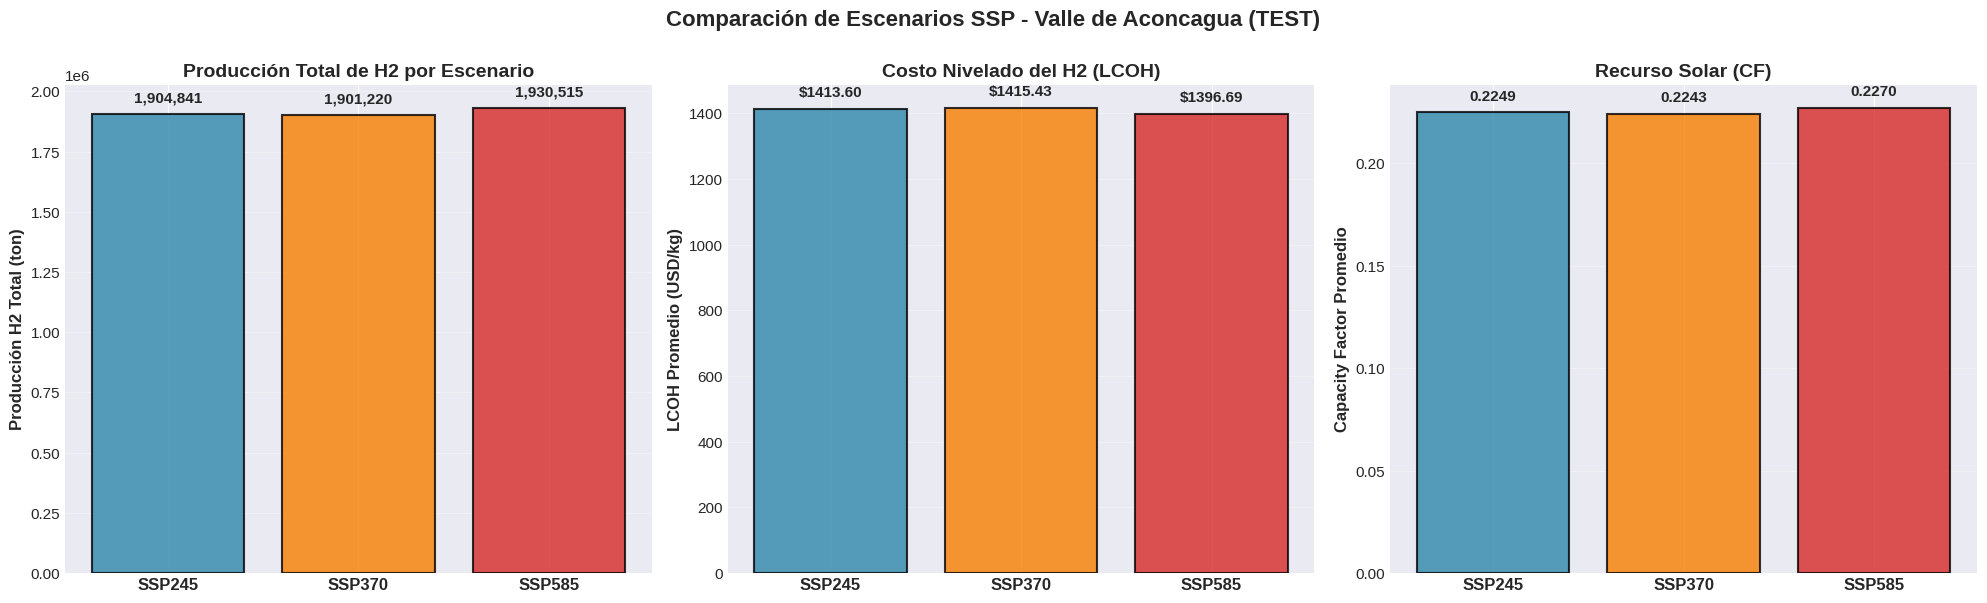

In [6]:
# Gráfico de barras comparativo
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Colores por escenario
colors = {'ssp245': '#2E86AB', 'ssp370': '#F77F00', 'ssp585': '#D62828'}

# 1. Producción H2 Total
ax1 = axes[0]
scenarios_plot = [s for s in SCENARIOS if s in results]
h2_totals = [results[s]['df']['h2_prod_ton'].sum() for s in scenarios_plot]
bars1 = ax1.bar(range(len(scenarios_plot)), h2_totals, 
                color=[colors[s] for s in scenarios_plot], alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_xticks(range(len(scenarios_plot)))
ax1.set_xticklabels([s.upper() for s in scenarios_plot], fontsize=12, fontweight='bold')
ax1.set_ylabel('Producción H2 Total (ton)', fontsize=12, fontweight='bold')
ax1.set_title('Producción Total de H2 por Escenario', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
# Agregar valores sobre las barras
for i, (bar, val) in enumerate(zip(bars1, h2_totals)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(h2_totals)*0.02,
             f'{val:,.0f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. LCOH Promedio
ax2 = axes[1]
lcoh_avgs = [results[s]['df']['lcoh_usd_kg'].mean() for s in scenarios_plot]
bars2 = ax2.bar(range(len(scenarios_plot)), lcoh_avgs, 
                color=[colors[s] for s in scenarios_plot], alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_xticks(range(len(scenarios_plot)))
ax2.set_xticklabels([s.upper() for s in scenarios_plot], fontsize=12, fontweight='bold')
ax2.set_ylabel('LCOH Promedio (USD/kg)', fontsize=12, fontweight='bold')
ax2.set_title('Costo Nivelado del H2 (LCOH)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars2, lcoh_avgs)):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(lcoh_avgs)*0.02,
             f'${val:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 3. Capacity Factor Promedio
ax3 = axes[2]
cf_avgs = [results[s]['df']['cf_mean'].mean() for s in scenarios_plot]
bars3 = ax3.bar(range(len(scenarios_plot)), cf_avgs, 
                color=[colors[s] for s in scenarios_plot], alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.set_xticks(range(len(scenarios_plot)))
ax3.set_xticklabels([s.upper() for s in scenarios_plot], fontsize=12, fontweight='bold')
ax3.set_ylabel('Capacity Factor Promedio', fontsize=12, fontweight='bold')
ax3.set_title('Recurso Solar (CF)', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars3, cf_avgs)):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(cf_avgs)*0.02,
             f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.suptitle(f'Comparación de Escenarios SSP - Valle de Aconcagua ({MODE.upper()})', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()

# Guardar
fig_path = PLOTS_DIR / f'comparison_bars_{MODE}.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✅ Gráfico guardado: {fig_path.name}")

plt.show()

## 7️⃣ Gráfico 2: Distribuciones de Producción H2 por Escenario

✅ Gráfico guardado: distributions_test.png


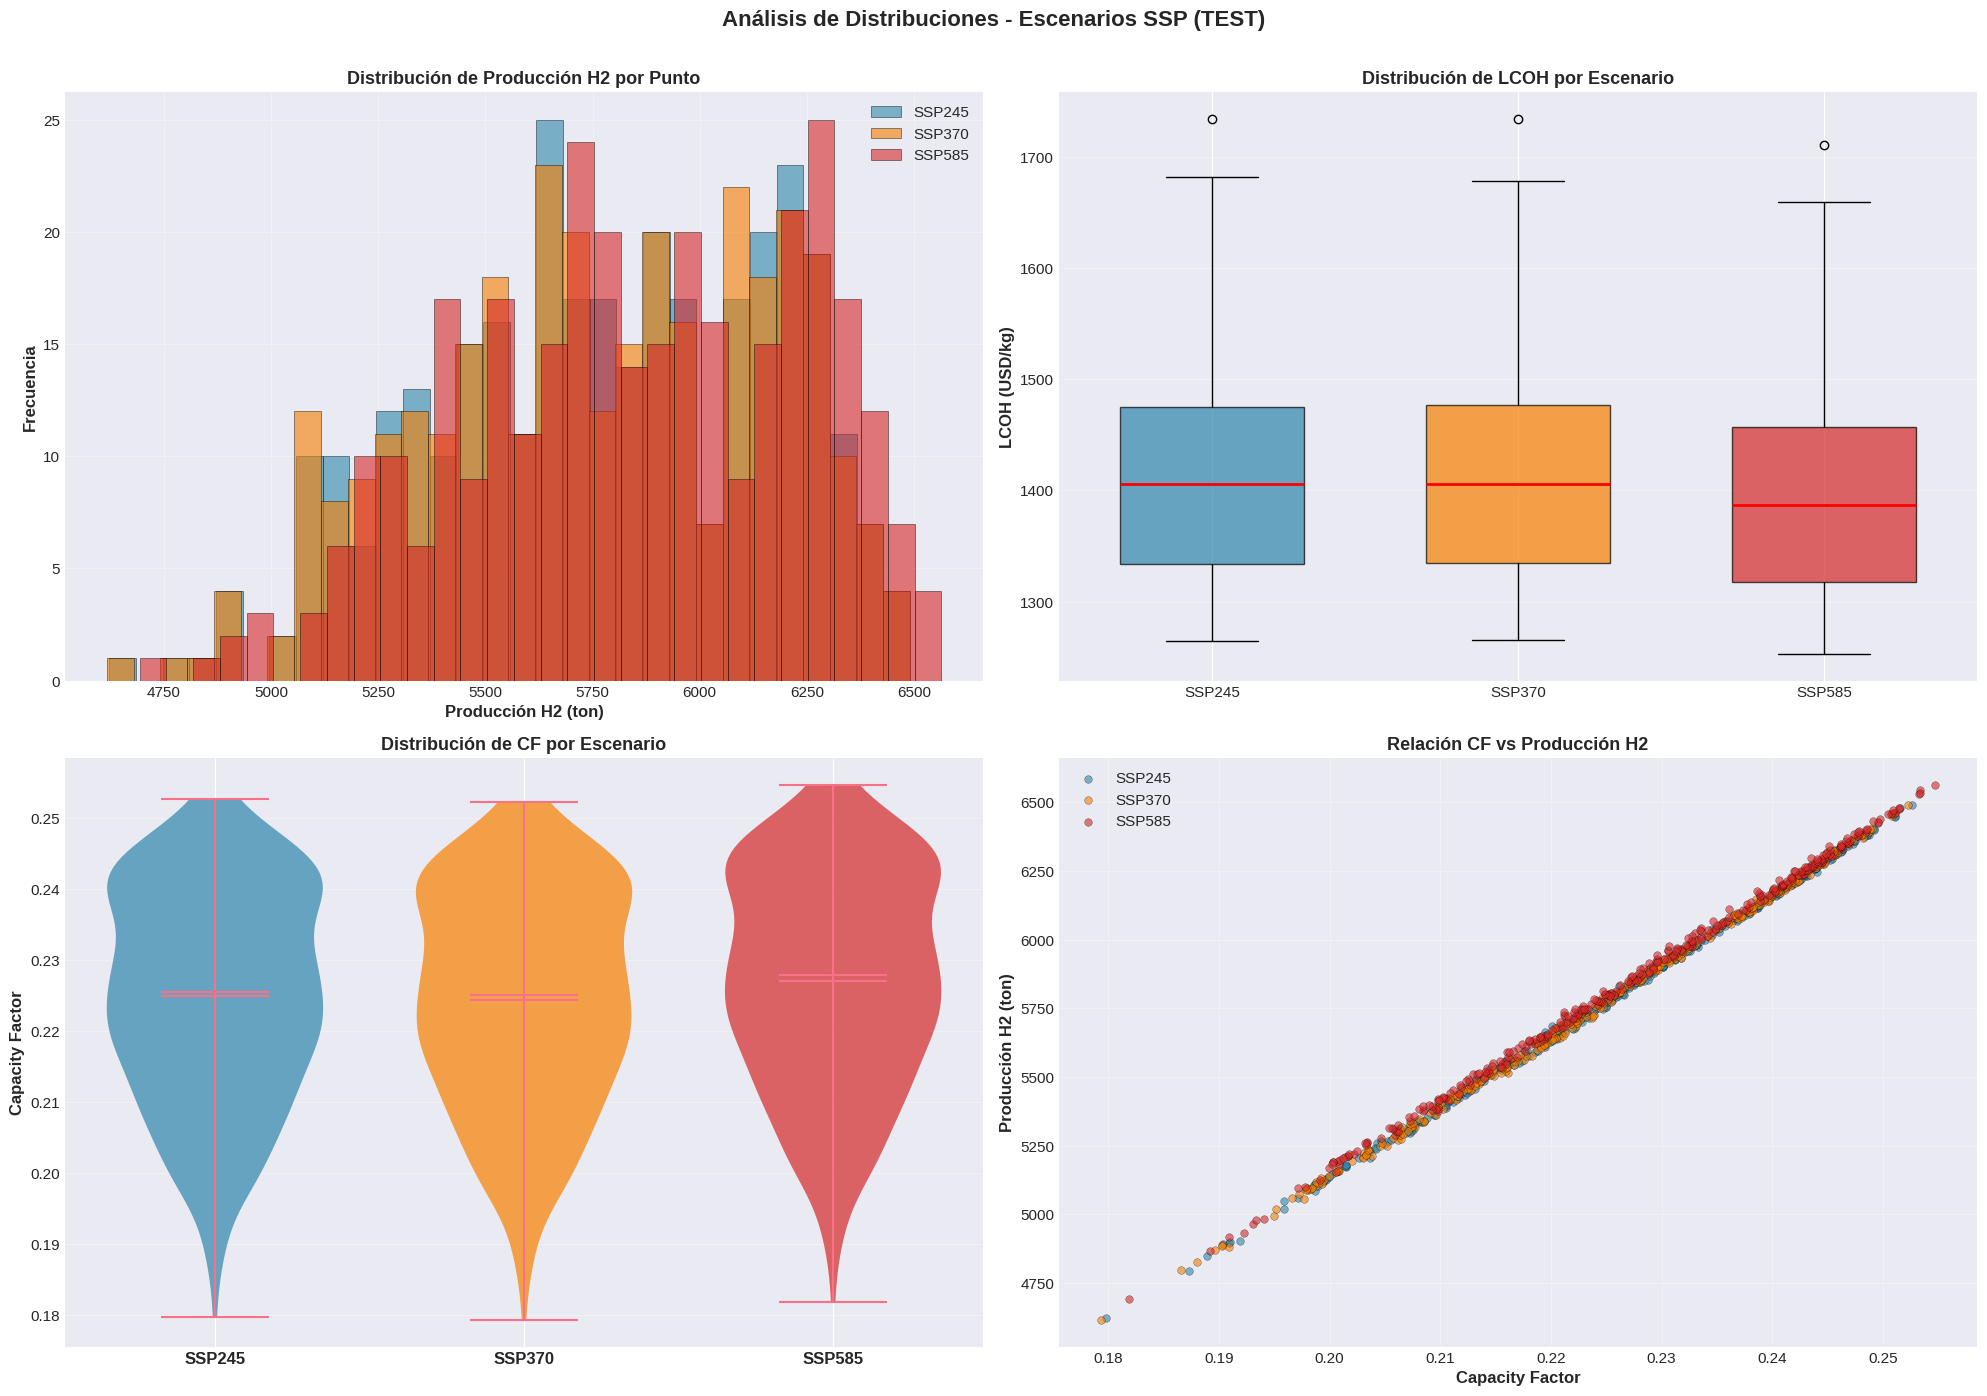

In [7]:
# Distribuciones (histogramas + boxplots)
fig, axes = plt.subplots(2, 2, figsize=(20, 14))

# 1. Histogramas de Producción H2
ax1 = axes[0, 0]
for scenario in scenarios_plot:
    df = results[scenario]['df']
    ax1.hist(df['h2_prod_ton'], bins=30, alpha=0.6, label=scenario.upper(), 
             color=colors[scenario], edgecolor='black', linewidth=0.5)
ax1.set_xlabel('Producción H2 (ton)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
ax1.set_title('Distribución de Producción H2 por Punto', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# 2. Boxplots de LCOH
ax2 = axes[0, 1]
lcoh_data = [results[s]['df']['lcoh_usd_kg'] for s in scenarios_plot]
bp = ax2.boxplot(lcoh_data, labels=[s.upper() for s in scenarios_plot], patch_artist=True,
                 widths=0.6, medianprops=dict(color='red', linewidth=2))
for patch, scenario in zip(bp['boxes'], scenarios_plot):
    patch.set_facecolor(colors[scenario])
    patch.set_alpha(0.7)
ax2.set_ylabel('LCOH (USD/kg)', fontsize=12, fontweight='bold')
ax2.set_title('Distribución de LCOH por Escenario', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# 3. Violin plots de Capacity Factor
ax3 = axes[1, 0]
cf_data_list = [results[s]['df']['cf_mean'] for s in scenarios_plot]
parts = ax3.violinplot(cf_data_list, positions=range(len(scenarios_plot)), 
                       showmeans=True, showmedians=True, widths=0.7)
for pc, scenario in zip(parts['bodies'], scenarios_plot):
    pc.set_facecolor(colors[scenario])
    pc.set_alpha(0.7)
ax3.set_xticks(range(len(scenarios_plot)))
ax3.set_xticklabels([s.upper() for s in scenarios_plot], fontsize=12, fontweight='bold')
ax3.set_ylabel('Capacity Factor', fontsize=12, fontweight='bold')
ax3.set_title('Distribución de CF por Escenario', fontsize=13, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# 4. Scatter: CF vs H2 producido
ax4 = axes[1, 1]
for scenario in scenarios_plot:
    df = results[scenario]['df']
    ax4.scatter(df['cf_mean'], df['h2_prod_ton'], alpha=0.6, s=30, 
                label=scenario.upper(), color=colors[scenario], edgecolors='black', linewidth=0.3)
ax4.set_xlabel('Capacity Factor', fontsize=12, fontweight='bold')
ax4.set_ylabel('Producción H2 (ton)', fontsize=12, fontweight='bold')
ax4.set_title('Relación CF vs Producción H2', fontsize=13, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(alpha=0.3)

plt.suptitle(f'Análisis de Distribuciones - Escenarios SSP ({MODE.upper()})', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])

# Guardar
fig_path = PLOTS_DIR / f'distributions_{MODE}.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✅ Gráfico guardado: {fig_path.name}")

plt.show()

## 8️⃣ Gráfico 3: Evolución Temporal del Capacity Factor

  SSP245: cf_var='cf_monthly', shape=(20, 20, 1032), cf_mean.shape=(1032,)
  SSP370: cf_var='cf_monthly', shape=(20, 20, 1032), cf_mean.shape=(1032,)
  SSP585: cf_var='cf_monthly', shape=(20, 20, 1032), cf_mean.shape=(1032,)
✅ Gráfico guardado: temporal_cf_test.png


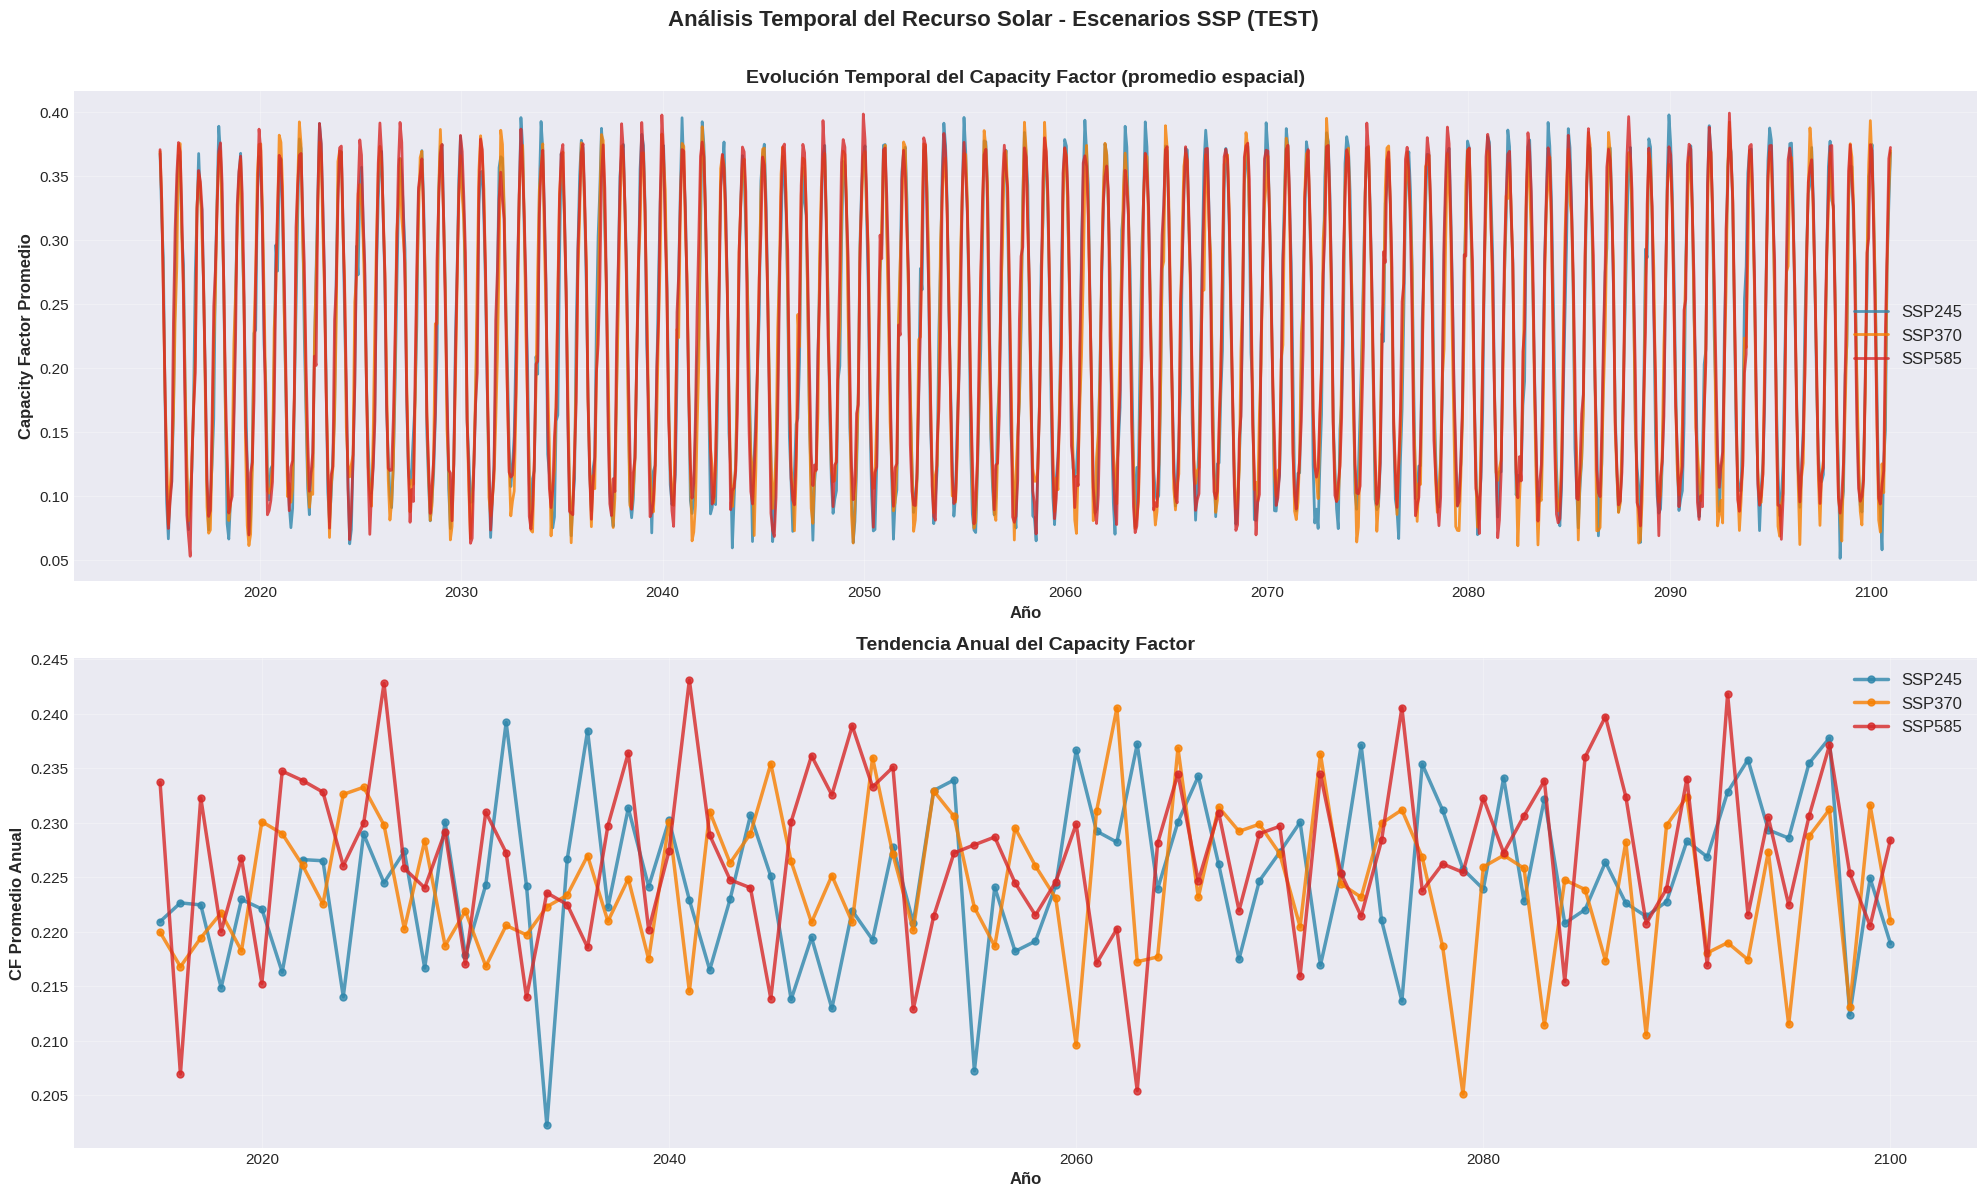

In [9]:
# Análisis temporal de CF
if len(cf_data) > 0:
    fig, axes = plt.subplots(2, 1, figsize=(20, 12))
    
    # 1. Serie temporal promedio
    ax1 = axes[0]
    for scenario in scenarios_plot:
        if scenario in cf_data:
            ds = cf_data[scenario]
            
            # Obtener la variable CF correcta (debe tener dimensión time)
            # Buscar variable con dimensión 'time'
            cf_var = None
            for var_name in ds.data_vars:
                if 'time' in ds[var_name].dims:
                    cf_var = var_name
                    break
            
            if cf_var is None:
                print(f"⚠️ No se encontró variable con dimensión 'time' en {scenario}")
                continue
            
            # Calcular promedio espacial (promedio sobre lat y lon, mantener time)
            cf_mean = ds[cf_var].mean(dim=['lat', 'lon']).values
            time_index = pd.to_datetime(ds.time.values)
            
            print(f"  {scenario.upper()}: cf_var='{cf_var}', shape={ds[cf_var].shape}, cf_mean.shape={cf_mean.shape}")
            
            ax1.plot(time_index, cf_mean, label=scenario.upper(), 
                     color=colors[scenario], linewidth=2, alpha=0.8)
    
    ax1.set_xlabel('Año', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Capacity Factor Promedio', fontsize=12, fontweight='bold')
    ax1.set_title('Evolución Temporal del Capacity Factor (promedio espacial)', 
                  fontsize=14, fontweight='bold')
    ax1.legend(fontsize=12, loc='best')
    ax1.grid(alpha=0.3)
    
    # 2. Promedio anual
    ax2 = axes[1]
    for scenario in scenarios_plot:
        if scenario in cf_data:
            ds = cf_data[scenario]
            
            # Obtener variable CF con dimensión time
            cf_var = None
            for var_name in ds.data_vars:
                if 'time' in ds[var_name].dims:
                    cf_var = var_name
                    break
            
            if cf_var is None:
                continue
            
            # Calcular serie temporal promediada espacialmente
            cf_series = ds[cf_var].mean(dim=['lat', 'lon']).to_pandas()
            
            # Resample a anual
            cf_annual = cf_series.resample('YE').mean()
            
            ax2.plot(cf_annual.index.year, cf_annual.values, 
                     marker='o', markersize=5, label=scenario.upper(), 
                     color=colors[scenario], linewidth=2.5, alpha=0.8)
    
    ax2.set_xlabel('Año', fontsize=12, fontweight='bold')
    ax2.set_ylabel('CF Promedio Anual', fontsize=12, fontweight='bold')
    ax2.set_title('Tendencia Anual del Capacity Factor', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=12, loc='best')
    ax2.grid(alpha=0.3)
    
    plt.suptitle(f'Análisis Temporal del Recurso Solar - Escenarios SSP ({MODE.upper()})', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    
    # Guardar
    fig_path = PLOTS_DIR / f'temporal_cf_{MODE}.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"✅ Gráfico guardado: {fig_path.name}")
    
    plt.show()
else:
    print("⚠️ No hay datos CF disponibles para análisis temporal")

## 9️⃣ Gráfico 4: Mapas Comparativos Espaciales

✅ Gráfico guardado: spatial_maps_test.png


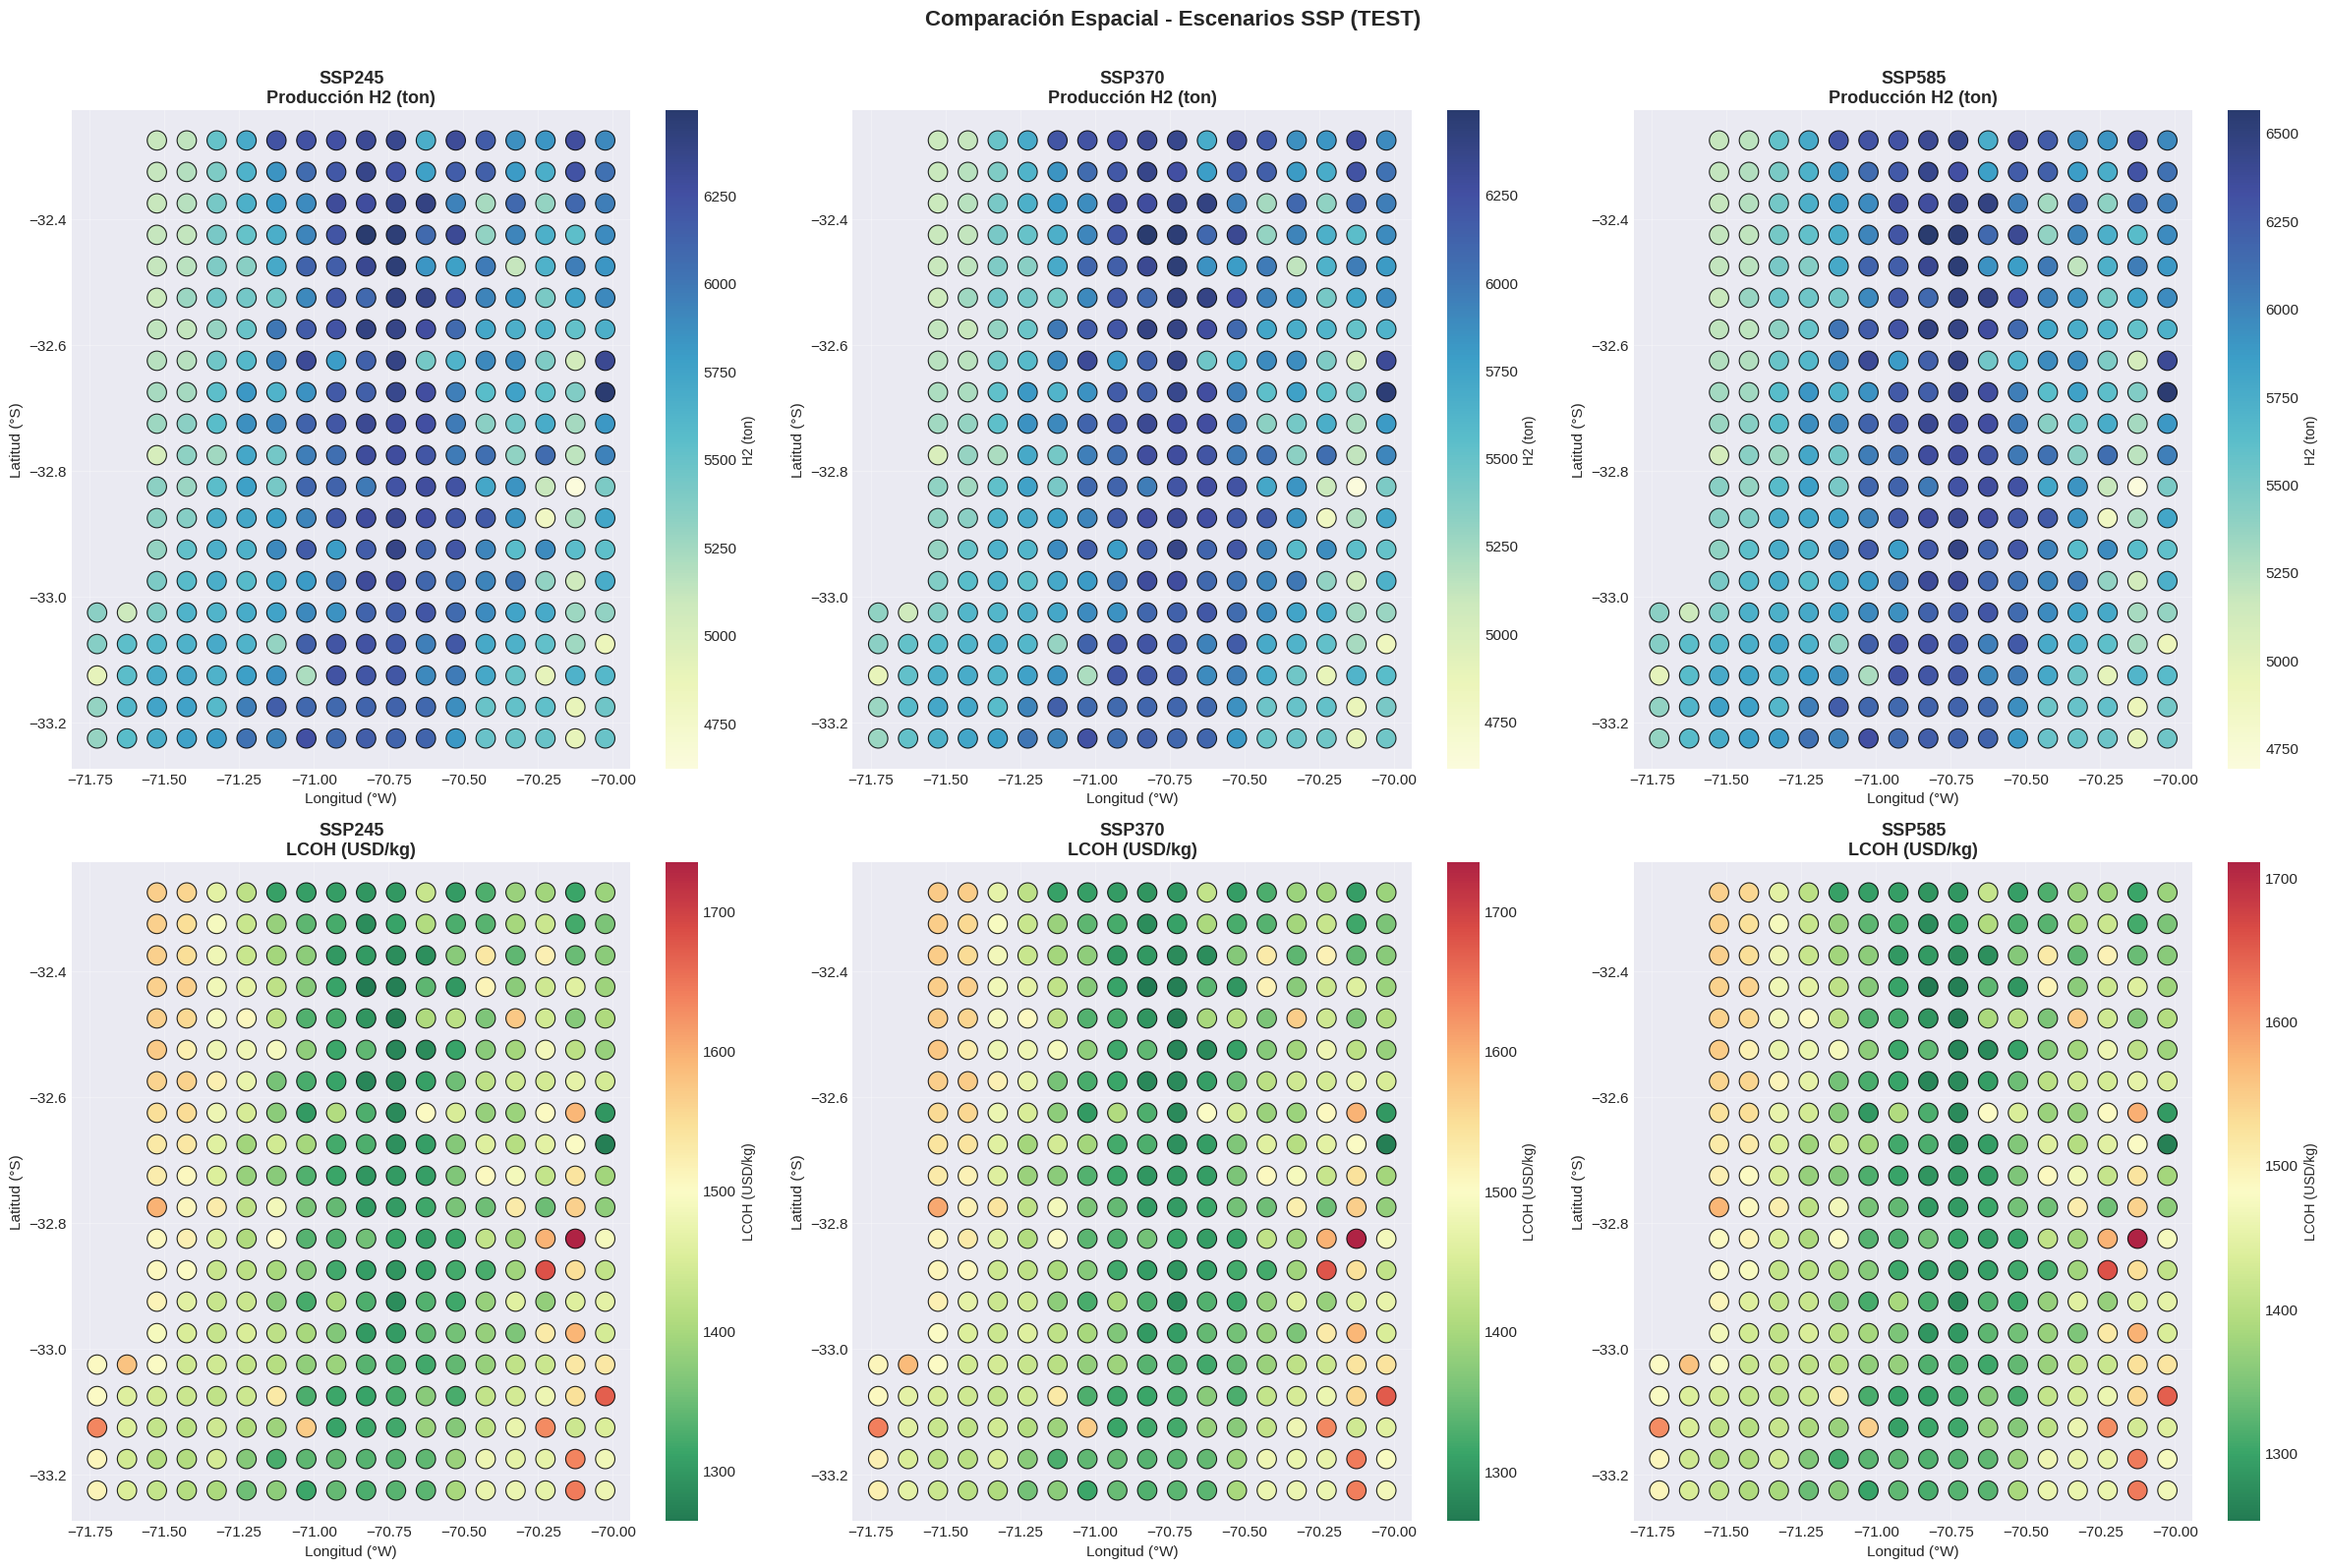

In [10]:
# Mapas espaciales comparativos
fig, axes = plt.subplots(2, 3, figsize=(24, 16))

# Fila 1: Producción H2
for i, scenario in enumerate(scenarios_plot):
    ax = axes[0, i]
    df = results[scenario]['df']
    
    scatter = ax.scatter(df['lon'], df['lat'], c=df['h2_prod_ton'], 
                        s=200, cmap='YlGnBu', edgecolors='black', linewidth=0.8, 
                        alpha=0.85, vmin=df['h2_prod_ton'].min(), vmax=df['h2_prod_ton'].max())
    ax.set_title(f'{scenario.upper()}\nProducción H2 (ton)', fontsize=13, fontweight='bold')
    ax.set_xlabel('Longitud (°W)', fontsize=11)
    ax.set_ylabel('Latitud (°S)', fontsize=11)
    ax.grid(True, alpha=0.3)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('H2 (ton)', fontsize=10)

# Fila 2: LCOH
for i, scenario in enumerate(scenarios_plot):
    ax = axes[1, i]
    df = results[scenario]['df']
    
    scatter = ax.scatter(df['lon'], df['lat'], c=df['lcoh_usd_kg'], 
                        s=200, cmap='RdYlGn_r', edgecolors='black', linewidth=0.8, 
                        alpha=0.85, vmin=df['lcoh_usd_kg'].min(), vmax=df['lcoh_usd_kg'].max())
    ax.set_title(f'{scenario.upper()}\nLCOH (USD/kg)', fontsize=13, fontweight='bold')
    ax.set_xlabel('Longitud (°W)', fontsize=11)
    ax.set_ylabel('Latitud (°S)', fontsize=11)
    ax.grid(True, alpha=0.3)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('LCOH (USD/kg)', fontsize=10)

plt.suptitle(f'Comparación Espacial - Escenarios SSP ({MODE.upper()})', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])

# Guardar
fig_path = PLOTS_DIR / f'spatial_maps_{MODE}.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✅ Gráfico guardado: {fig_path.name}")

plt.show()

## 🔟 Análisis de Sensibilidad Climática

In [11]:
# Análisis de sensibilidad
print("=" * 80)
print("🔬 ANÁLISIS DE SENSIBILIDAD CLIMÁTICA")
print("=" * 80)

if len(results) >= 2:
    # Correlaciones entre escenarios
    print("\n📊 Correlaciones de Producción H2 entre Escenarios:")
    print("-" * 80)
    
    for i, sc1 in enumerate(scenarios_plot):
        for sc2 in scenarios_plot[i+1:]:
            # Merge por coordenadas
            df1 = results[sc1]['df'][['lat', 'lon', 'h2_prod_ton']].copy()
            df2 = results[sc2]['df'][['lat', 'lon', 'h2_prod_ton']].copy()
            
            df1['coord'] = df1['lat'].round(5).astype(str) + '_' + df1['lon'].round(5).astype(str)
            df2['coord'] = df2['lat'].round(5).astype(str) + '_' + df2['lon'].round(5).astype(str)
            
            merged = df1.merge(df2, on='coord', suffixes=('_1', '_2'))
            
            if len(merged) > 0:
                corr = merged['h2_prod_ton_1'].corr(merged['h2_prod_ton_2'])
                print(f"  {sc1.upper()} vs {sc2.upper()}: {corr:.4f}")
    
    # Variabilidad espacial
    print("\n📍 Variabilidad Espacial (CV = std/mean):")
    print("-" * 80)
    for scenario in scenarios_plot:
        df = results[scenario]['df']
        cv_h2 = df['h2_prod_ton'].std() / df['h2_prod_ton'].mean()
        cv_lcoh = df['lcoh_usd_kg'].std() / df['lcoh_usd_kg'].mean()
        print(f"  {scenario.upper()}:")
        print(f"    CV H2: {cv_h2:.4f}")
        print(f"    CV LCOH: {cv_lcoh:.4f}")
    
    # Puntos óptimos consistentes
    print("\n🎯 Puntos Óptimos Consistentes (Top 10% en todos los escenarios):")
    print("-" * 80)
    
    top_sets = []
    for scenario in scenarios_plot:
        df = results[scenario]['df'].copy()
        threshold = df['h2_prod_ton'].quantile(0.9)
        top_points = set(zip(df[df['h2_prod_ton'] >= threshold]['lat'].round(5), 
                            df[df['h2_prod_ton'] >= threshold]['lon'].round(5)))
        top_sets.append(top_points)
    
    # Intersección de top points
    common_top = set.intersection(*top_sets)
    print(f"  Puntos en Top 10% de TODOS los escenarios: {len(common_top)}")
    
    if len(common_top) > 0:
        print(f"\n  Primeros 5 puntos consistentes:")
        for i, (lat, lon) in enumerate(list(common_top)[:5], 1):
            print(f"    {i}. Lat: {lat:.3f}, Lon: {lon:.3f}")

print("\n" + "=" * 80)

🔬 ANÁLISIS DE SENSIBILIDAD CLIMÁTICA

📊 Correlaciones de Producción H2 entre Escenarios:
--------------------------------------------------------------------------------
  SSP245 vs SSP370: 0.9995
  SSP245 vs SSP585: 0.9997
  SSP370 vs SSP585: 0.9994

📍 Variabilidad Espacial (CV = std/mean):
--------------------------------------------------------------------------------
  SSP245:
    CV H2: 0.0679
    CV LCOH: 0.0639
  SSP370:
    CV H2: 0.0688
    CV LCOH: 0.0647
  SSP585:
    CV H2: 0.0668
    CV LCOH: 0.0630

🎯 Puntos Óptimos Consistentes (Top 10% en todos los escenarios):
--------------------------------------------------------------------------------
  Puntos en Top 10% de TODOS los escenarios: 32

  Primeros 5 puntos consistentes:
    1. Lat: -32.625, Lon: -70.725
    2. Lat: -32.275, Lon: -70.125
    3. Lat: -32.725, Lon: -70.825
    4. Lat: -32.875, Lon: -70.825
    5. Lat: -32.775, Lon: -70.725



## 1️⃣1️⃣ Exportar Resumen Comparativo

In [12]:
# Guardar tabla comparativa
comparison_csv = PLOTS_DIR / f'comparison_summary_{MODE}.csv'
df_comparison.to_csv(comparison_csv, index=False)
print(f"✅ Tabla comparativa guardada: {comparison_csv.name}")

# Resumen de archivos generados
print("\n" + "=" * 80)
print("📁 ARCHIVOS GENERADOS")
print("=" * 80)
print(f"\nDirectorio: {PLOTS_DIR}\n")
for file in sorted(PLOTS_DIR.glob(f'*_{MODE}.*')):
    print(f"  ✓ {file.name}")
print("\n" + "=" * 80)

✅ Tabla comparativa guardada: comparison_summary_test.csv

📁 ARCHIVOS GENERADOS

Directorio: /home/aninotna/magister/tesis/justh2_pipeline/plots/ssp_comparison

  ✓ comparison_bars_test.png
  ✓ comparison_summary_test.csv
  ✓ distributions_test.png
  ✓ spatial_maps_test.png
  ✓ temporal_cf_test.png



---

## ✅ Resumen del Análisis

Este notebook genera:

1. **Tabla comparativa** con estadísticas agregadas por escenario
2. **Gráficos de barras** comparando H2 total, LCOH y CF
3. **Distribuciones** (histogramas, boxplots, violin plots)
4. **Series temporales** de evolución del CF
5. **Mapas espaciales** comparativos de H2 y LCOH
6. **Análisis de sensibilidad** y correlaciones entre escenarios

### 📊 Outputs:
- `comparison_bars_{mode}.png`
- `distributions_{mode}.png`
- `temporal_cf_{mode}.png`
- `spatial_maps_{mode}.png`
- `comparison_summary_{mode}.csv`